In [2]:
import pandas as pd
import numpy as np
import sqlite3, os
from huggingface_hub import login, logout
from datasets import load_dataset
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from util.util_data import special_encode, makeRegex, splitData
from util.util_kwrds import class_keywords, extract_keywords
import torch
import logging
logging.getLogger("pytorch_pretrained_bert.tokenization").setLevel(logging.ERROR)

# **1. Clinical Trial Announcements**

In [3]:
engine = sqlite3.connect('./src/data.db')
OUT = 'out'
catalyst = pd.read_sql('SELECT * FROM catalysts', engine)
catalyst.head()

,ticker,disease,stage,date,catalyst
0,SPPI,Non-Hodgkin’s lymphoma,Approved,2009-09-04 00:00:00,"Approved September 4, 2009."
1,JAZZ,Fibromyalgia,CRL,2010-10-11 00:00:00,"CRL received October 11, 2010."
2,ASRT,Postherpetic neuralgia - shingles,Approved,2011-01-28 00:00:00,"Approved January 28, 2011."
3,ASRT,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011."
4,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011."


<Axes: ylabel='stage'>

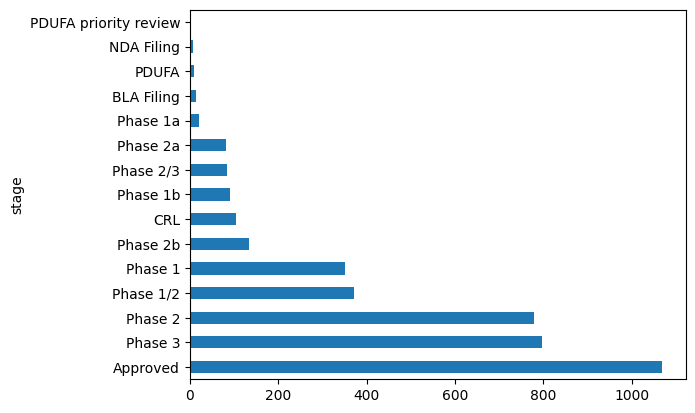

In [3]:
catalyst['stage'].value_counts().plot(kind='barh')

## **1.1 Initial Rule-Based Labeling**

In [57]:
dove = makeRegex(["approv", "meet", "show", "reach"])
hawk = makeRegex(["halt", "fail", "no diff", "stop"]) +\
    makeRegex(dove, neg=True)
labs_init = catalyst['catalyst'].apply(special_encode,
                                       bull_words=dove,
                                       bear_words=hawk)

In [58]:
labs_init.value_counts()

catalyst
 0    2087
 1    1786
-1      38
Name: count, dtype: int64

<Axes: ylabel='catalyst'>

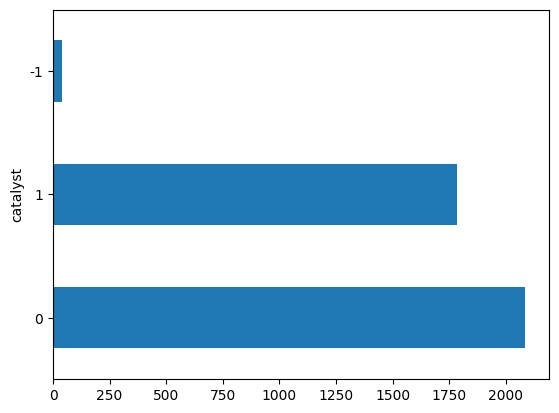

In [48]:
# 1: Dovish; 0: Neutral; -1: Hawkish
labs_init.value_counts().plot(kind='barh')

## **1.2 Keyword Generation with BioBERT**

In [7]:
#  NOTE: change if needed
#  "dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0" BioBERT
#  "roberta-large-mnli" RoBERTa Large
filtered_words = [i for i in stopwords.words('english') if i not in  ["no", "not"]]
model = SentenceTransformer('dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0') # fine-tuned bioBERT
key_words = catalyst['catalyst'].apply(extract_keywords, stop_words=filtered_words, model=model) # generate keywords
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0") # tokenizer
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0") # classifier
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=torch.device('cpu'), framework='pt', truncation=True)

No sentence-transformers model found with name /Users/MicheleOrlandi/.cache/torch/sentence_transformers/dmis-lab_TinySapBERT-from-TinyPubMedBERT-v1.0. Creating a new one with MEAN pooling.


In [10]:
class_kwrds = class_keywords(classifier=classifier, kwrds=key_words) # sentiment analysis on generated keywords

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [29]:
class_kwrds.head()

,label,score,keywords
7688,LABEL_0,0.680992,efficacy improvements bcva
7549,LABEL_0,0.671888,showed improvements bcva
8289,LABEL_0,0.667436,bcva maintained extension
9885,LABEL_0,0.654310,pain extended effect
19363,LABEL_0,0.652233,potential benefits tachyphylaxis
6518,LABEL_0,0.651554,ctc reductions treatment
17738,LABEL_0,0.651109,pancreatic cancer conference
9731,LABEL_0,0.650005,bcva noted
18012,LABEL_0,0.647244,bcva gain months
18010,LABEL_0,0.646928,bcva gain


In [59]:
# compared outputs from BioBERT or RoBERTa to improve our keyword selection to build ground truth labels
dove_bert = [
    "preserv", "eval", "improv", "met",\
        "present", "observ", "achiev", "attain",\
            "favor", "toler", "treat", "reduc"] # manually inspected better labels
hawk_bert = [
    "discontinu", "terminat", "pause", "insuffic"
]
hawk_bert = makeRegex(dove_bert, neg=True) + makeRegex(hawk_bert) + hawk
dove_bert = makeRegex(dove_bert) + dove
labs_new = catalyst['catalyst'].apply(special_encode,
                                        bull_words=dove_bert,
                                        bear_words=hawk_bert)

In [60]:
labs_new.value_counts()

catalyst
 1    3117
 0     672
-1     122
Name: count, dtype: int64

<Axes: ylabel='catalyst'>

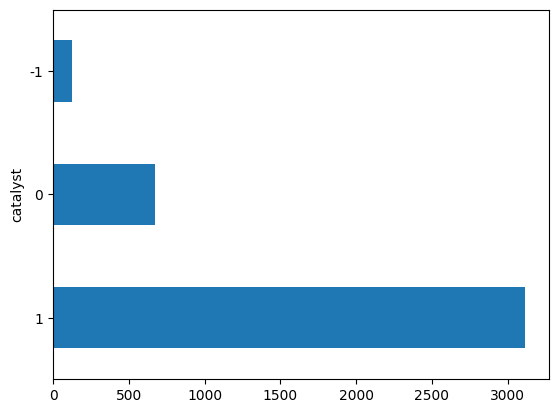

In [61]:
labs_new.value_counts().plot(kind='barh')

# **2. Dataset Creation**

In [63]:
# add better labels to dataframe
catalyst['label'] = labs_new
catalyst.head()

,ticker,disease,stage,date,catalyst,label
0,SPPI,Non-Hodgkin’s lymphoma,Approved,2009-09-04 00:00:00,"Approved September 4, 2009.",1
1,JAZZ,Fibromyalgia,CRL,2010-10-11 00:00:00,"CRL received October 11, 2010.",0
2,ASRT,Postherpetic neuralgia - shingles,Approved,2011-01-28 00:00:00,"Approved January 28, 2011.",1
3,ASRT,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1
4,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1


In [4]:
train, test = splitData(df=catalyst)

In [14]:
train.head()

,ticker,disease,stage,date,catalyst
714,JNJ,Diabetic Kidney Disease,Approved,2019-09-30 00:00:00,"FDA Approval announced September 30, 2019."
2143,HLVX,GI.1/GII.4 virus-like particle (VLP) vaccine,Phase 2,2022-07-20 00:00:00,Phase 2 data reported that Pan-Ig and HBGA blo...
118,IRWD,Chronic idiopathic constipation (CIC),Approved,2017-01-26 00:00:00,"sNDA approval announced January 26, 2017."
2519,LGND,Chronic obstructive pulmonary disease (COPD),Phase 3,2022-12-20 00:00:00,ENHANCE-1 Phase 3 topline data met its primary...
1295,CMRX,Acute lung injury (ALI) in COVID-19,Phase 2,2021-05-06 00:00:00,"Phase 2 initial data released May 6, 2021. One..."
...,...,...,...,...,...
1120,SYRS,Myelodysplastic Syndrome,Phase 2,2020-12-05 00:00:00,"Phase 2 presentation December 5, 2020 at ASH. ..."
1769,AMGN,Asthma,Approved,2021-12-17 00:00:00,"Approved December 17, 2021."
2757,AVIR,COVID-19,Phase 2,2023-04-25 00:00:00,"Fast Track Designation granted on April 25, 2023."
539,OPNT,Bulimia Nervosa,Phase 2,2019-02-21 00:00:00,"Phase 2 data released February 21, 2019. Endpo..."


In [212]:
if OUT not in os.listdir(os.getcwd()):
    os.mkdir(OUT)
train.to_csv(f"{OUT}/train.csv", index=0)
test.to_csv(f"{OUT}/test.csv", index=0)
catalyst.to_csv(f"{OUT}/catalyst.csv", index=0)


In [214]:
login()


In [215]:
dataset = load_dataset("quant-chef/BioPharmaCatalysts")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ticker', 'disease', 'stage', 'date', 'catalyst', 'label'],
        num_rows: 3128
    })
    test: Dataset({
        features: ['ticker', 'disease', 'stage', 'date', 'catalyst', 'label'],
        num_rows: 783
    })
})

In [216]:
logout()


Successfully logged out.
